## 3D-Printing using Turtle Graphics
- A "Turtle Graphics" approach is used to define the extrusion paths:  A series of `(segment length, change of heading angle)` - tuples defines a path segment. e.g. the tuple `(2*pi ,2*pi)` defines a unit circle, the tuple `(1,0)` a straight line of unit length, and `(0,-30*deg)` turns on the spot `30deg` to the right.
- Complex numbers are used for the 2D coordinates:  2D translations and rotations are simple additions and multiplications of complex numbers. E.g. the complex expression `(3+5j)*1j**(30/90)` rotates the point `(x=3,y=5)` counter-clockwise by `30deg` around the origin.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign

def polygonArea(p):
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def SegmentsLengthArea(Segs):
  nSegs=len(Segs)
  dl,dang=np.array(Segs).transpose()
  l=sum(dl)
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')#suppress the warnings from 0/0 = nan. nansum assumes nan=0, which is the correct value in this case
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return l,area

def InterpSegments(Segs,t,p0=0+0j,a0=1+0j,scale=1.0,return_headings=False,eps=1e-6):
  """
  Segment points are calculated for values of 't', where 't' is the normalized
  length of the path. t is in the range of [0..1[
  """
  dl,dang=np.array(Segs).transpose()
  l,ang_=np.cumsum([(0,0)]+Segs,axis=0).transpose()
  ang=exp(1j*ang_)
  viSeg=np.sinc(dang/(2*pi))*dl*scale*np.exp(1j*dang/2)*ang[:-1]
  pSeg=np.cumsum(np.insert(viSeg,0,0+0j))
  T=t.astype(int)
  if ((abs(pSeg[-1])<eps) and (abs(ang[-1]-(1+0j))<eps)):
    pr,ar=np.zeros((len(t),)), np.ones((len(t),)) # closed loop. No translation/rotation necessary for t>1
  else: #endpoint of path != startpoint => repeat path for t>1 by translating and rotating it
    def rotateSecant(v,beta,T):
      beta2=beta/2
      rot2=exp(1j*beta2)
      uniqueT,inverseIndex=np.unique(T,return_inverse=True) #don't re-calculate for identical values of T
      p=(v*rot2**(uniqueT-1)/np.sinc(beta2/np.pi) * uniqueT * np.sinc(uniqueT*beta2/np.pi))[inverseIndex]
      a=(rot2**(2*uniqueT))[inverseIndex]
      return p,a
    pr,ar=rotateSecant(pSeg[-1],ang_[-1],T)
  pr+=p0
  ar*=a0
  l=l/l[-1]
  Xx=np.interp(np.array(t)%1,l,range(len(l)))
  X=Xx.astype(int) #segment index
  x=Xx%1 #within seggment
  p=pSeg[X] + np.sinc( dang[X]*x /(2*pi))* dl[X]*x *scale*np.exp(1j* dang[X]*x /2)*ang[X]
  p=p*ar+pr
  if not return_headings:
    return p
  else:
    a=ang[X]*np.exp(1j*dang[X]*x)*ar
    return p,a

def Segments2Complex(Segs,p0=0+0j,scale=1.0,a0=1+0j,tol=0.05,offs=0,loops=1,return_heading=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0
  p=p0
  p-=1j*a*offs
  for _ in range(loops):
      for l,da in Segs:
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for _ in range(n):
          p+=v
          if return_heading:
            yield p,a
          else:
            yield p
          v*=dda
          a*=dda

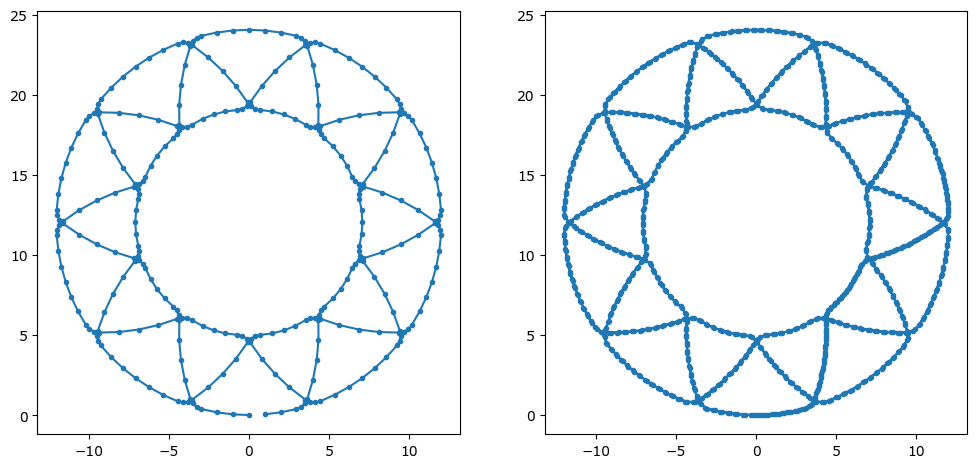

10

In [18]:
from math import pi
deg=pi/180
mirror=lambda a:a+a[::-1]
def mirror(a): return a+a[::-1]
def rackSegment(l=1,w1=0.5,w2=0.5,r1=0.1,r2=0.1,a=60*deg,c=0*deg,da=0,daw=0):return mirror([(w1/2,daw/2),(r1*a,a+da/4-daw/2-c/4),(l,c/2),(r2*a,-a+da/4-daw/2-c/4),(w2/2,daw/2)])
#ns,nc=20,3
#ns,nc=21,4
ns,nc=10,3
rs=rackSegment(w1=0.575,w2=0.3,r1=0.2,r2=0.2,da=2*pi/(ns/nc),daw=0.8* 2*pi/ns)
rs=rackSegment(w1=1.2,w2=0.6,r1=0.2,r2=0.2,a=55*deg,da=2*pi/(ns/nc),c=45*deg,daw=0.8* 2*pi/ns)

pr1=np.array(list(Segments2Complex(rs,scale=5,tol=0.02,loops=ns))).transpose()
#pr1=np.array(list(Segments2Complex([(1,0),(0,60*deg),(0.5,0)],scale=5,tol=0.02,loops=21))).transpose()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.plot(pr1.real,pr1.imag,'.-')
n=1000
t=np.linspace(1/n,21,n)
pr2=InterpSegments(rs,t,a0=1,p0=0+0j,scale=5)
#pr2=InterpSegments([(1,0),(0,60*deg),(0.5,0)],t,a0=1,p0=0+0j,scale=1)
ax2.plot(pr2.real,pr2.imag,'.-')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.show()
len(pr1)
len(rs)

In [11]:
import io
from PIL import Image
import matplotlib.pyplot as plt
def save_gif_animation(image_generator,output_file):
    durations=list(image_generator('duration'))
    imgs=image_generator('img')
    img=next(imgs)
    img.save(fp=output_file, format='GIF', append_images=imgs,
                 save_all=True, duration=durations, loop=0)
    
def show_animation_frames(image_generator,frames=None):
    for i,frame in enumerate(image_generator('fig')):
        if (frame==None) or  (i in frames):
            display(frame)
            
def gen_ani(returntype='fig'):  #fig,dur,img
  frame=0
  def snapshot(fig=None,duration=200,params=None):
      nonlocal frame #frame counter
      if fig==None: fig=plt.gca()
          
      if params==None: params=dict() #create a new local dict, because dict is mutable
  #    ax.set_title(f'frame #{frame}, duration:{duration}')
      framelabel=fig.text(0.,0., f'{frame}')
      if returntype=='fig':
        yield fig
      elif returntype=='duration':
        yield duration
      elif returntype=='img':
        with io.BytesIO() as img_buf:  
          fig.savefig(img_buf, format='png')
          yield Image.open(img_buf)
      else:
        raise Exception(f'Wrong value for "returntype": gen_any(returntype={returntype})\n'
                        "(must be [ 'fig' | 'duration' | 'img' ] )")
        return
      frame+=1
      framelabel.remove()
      return
  fig=plt.figure(figsize=(6.4,4)) 
  ax=fig.add_axes((0,0,0.75,1))
 # ax.set_xlim(-14,28)
 # ax.set_ylim(0,28)
  ax.set_aspect('equal')
  ax.set_axis_off()
  duration=500
  yield from snapshot(fig=fig,duration=duration,params=dict())
  pr1=np.array([0]+list(Segments2Complex(rs,scale=5,tol=0.02,loops=ns))).transpose()
  js=len(pr1)//(2*ns) 
  for j in range(1,len(pr1)):
      if (j>=(2*js)) and (j%js!=0) and (j!=(len(pr1)-1)):
          continue  
      ax.plot(pr1[:min(js,j)+1].real,pr1[:min(js,j)+1].imag,'-',color='r',label='turtle path')
      if j>=js: ax.plot(pr1[js:min(2*js,j)+1].real,pr1[js:min(2*js,j)+1].imag,'-',color='g',label='mirrored') 
      if j>=2*js: ax.plot(pr1[2*js:j+1].real,pr1[2*js:j+1].imag,'-',color='b',label='repeated')
      duration = 1000 if j in (len(pr1)-1,) else 200
      ax.legend(loc='upper left',bbox_to_anchor=(1.0, 0.95))
      yield from snapshot(fig=fig,duration=duration,params=dict())
      while ax.lines:
        ax.lines[0].remove()
  plt.close()
  return
#show_animation_frames(gen_ani,[1,2,3,4,5,10,15,21,30,40,50])
save_gif_animation(gen_ani,'turtle_mesh.gif')
print(f'saved')

saved


![turtle mesh animation](https://raw.githubusercontent.com/RichardPotthoff/myrepo/master/turtle_mesh.gif)

In [4]:
 if 'google.colab' in str(get_ipython()):
  try:
    import fullcontrol as fc
  except Exception as e:
    print(e)
    print('Attempting to install missing packages. Please wait ...')
    !pip install git+https://github.com/FullControlXYZ/fullcontrol --quiet
    import fullcontrol as fc
  from google.colab import files
from math import cos, tau

In [5]:
steps=[]
hl=0.2
FilamentDiameter=1.75
tol=0.03
nwipe=5
nskip=5
jt=0
nskirt=0
skirtoffs=1.5
ehmin=hl/2
p0=25+0j
a0=1j**(90/90)
Segments=rs
offs=0.0
scale=8
a0=1
p0=0
path=list(Segments2Complex(Segments,p0=p0,a0=a0,tol=tol,scale=scale,offs=offs,loops=ns))
r=max((-1j*p).real for p in path)/2
path=[p-r*1j for p in path]
rskirt=r+skirtoffs
p=-1j*rskirt
steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag,z=hl)))
steps.append(fc.Extruder(on=True))
n=200
dang=1j**(4/n)
for i in range(n):
  p*=dang
  steps.append(fc.Point(x=p.real,y=p.imag))
steps.append(fc.Extruder(on=False))
n=len(path)
zb=0
zt=zb+10
dzdj=hl/n
w=0.75
#print(w)
dwdj=0
old_eh=-1
old_w=-1
jt=0
p=path[-1]
z=zb+ehmin
steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag)))
steps.extend(fc.travel_to(fc.Point(z=z)))
steps.append(fc.Extruder(on=True))
#while False:
while  z<(zt+hl):
  jt=(jt+1)%n
  z+=dzdj
  w-=dwdj
  eh=min(z-zb if z<(zb+hl+ehmin) else hl ,zt-(z-hl))
  p=path[jt]
  if (abs(eh-old_eh)/hl)>0.01 or abs(w-old_w)>0.005:
   # print(f'{zb=}{z=}{zt=}{eh=}{w=}')
    steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=eh,width=w))
    old_eh=eh
    old_w=w
  steps.append(fc.Point(x=p.real,y=p.imag,z=min(z,zt)))
steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=0,y=0)))
# offset the whole procedure. z dictates the gap between the nozzle and the bed for the first layer, assuming the model was designed with a first layer z-position of 0
model_offset = fc.Vector(x=100, y=100, z=0.0*hl)
#print(f'{w=} {eh=}')
steps = fc.move(steps, model_offset)

NameError: name 'fc' is not defined

In [ ]:
# add annotations and plot
EW=1.0
EH=0.2
fc.transform(steps, 'plot', fc.PlotControls(color_type='print_sequence', initialization_data={'extrusion_width': EW, 'extrusion_height': EH}))

In [ ]:
#design parameters

design_name = 'turtlemesh'
nozzle_temp = 220
bed_temp = 120
print_speed = 30*60
fan_percent = 0
EH = 0.2    # extrusion heigth
EW = 0.5    # extrusion width
printer_name = 'generic'
#printer_name = 'Prusa_Mendel'
gcode_controls = fc.GcodeControls(
    printer_name=printer_name,
    save_as=design_name,
    initialization_data={
        'primer': 'no_primer',
        'print_speed': print_speed,
        'nozzle_temp': nozzle_temp,
        'bed_temp': bed_temp,
        'fan_speed':fan_percent,
         })
gcode = fc.transform(steps, 'gcode', gcode_controls)